### IMPORT STUFF HERE

pip install geopy

### IMPORT ALL THE FILES HERE

In [1]:
%%time
# Importing all the necessary libraries for this project.

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import datetime
import datetime as dt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import statsmodels.api as sm
from sklearn import metrics
from bs4 import BeautifulSoup
import requests
import time
from selenium import webdriver
import re
from selenium.webdriver.common.keys import Keys
from uuid import uuid4 as uuid
from datetime import datetime 
from pygeocoder import Geocoder
from time import sleep


/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


CPU times: user 1.6 s, sys: 455 ms, total: 2.05 s
Wall time: 2.54 s


### IMPORT ALL THE RELEVANT FILES

In [2]:
wnv_data = pd.read_csv("train.csv", error_bad_lines=False, low_memory=False)
test = pd.read_csv("test.csv", error_bad_lines=False, low_memory=False)


wnv_spray = pd.read_csv("spray.csv", error_bad_lines=False, low_memory=False)

wnv_weather = pd.read_csv("weather.csv", error_bad_lines=False, low_memory=False)

census_info = pd.read_csv("census_info.csv", error_bad_lines=False, low_memory=False)

census_age = pd.read_csv("census_age.csv", error_bad_lines=False, low_memory=False)

spray_recs = pd.read_csv("recommendation_data.csv", error_bad_lines=False, low_memory=False)


cols = ['2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016']
robin= pd.DataFrame([[7502,6923,6543,6123,6915,7003,7907,7343,7385,6814,6341,6538]],columns=cols)

### FIX CENSUS_INFO columns & dtypes

In [3]:
census_info = census_info.drop(["GEO.id", "GEO.display-label", "Unnamed: 0"], axis = 1)
census_info["zip_code"] = census_info["zip_code"].astype(str)

census_age = census_age.drop(["GEO.id", "GEO.display-label", "Unnamed: 0"], axis = 1)
census_age["zip_code"] = census_age["zip_code"].astype(str)

pd.set_option('display.max_columns', None)


### FUNCTION CELL. FIX ZIP_CODE & DATES, CHARS

In [4]:
def zip_code(x):
    if "60" in x.split()[-2]:
        zipcode = x.split()[-2].replace(",", "")
    elif "South Doty Avenue, Chicago, IL, USA" in x:
        zipcode = "60633"
    elif "South Stony Island Avenue, Chicago, IL, USA" in x:
        zipcode = "60617"
    elif "South Torrence Avenue, Chicago, IL, USA" in x:
        zipcode = "60617"
    elif "South Cottage Grove Avenue, Chicago, IL, USA" in x:
        zipcode = "60619"
    elif "South Vincennes Avenue, Chicago, IL, USA" in x:
        zipcode = "60620"
    elif "East 91st Place, Chicago, IL, USA" in x:
        zipcode = "60619"
    elif "West Garfield Boulevard, Chicago, IL, USA" in x:
        zipcode = "60636"
    elif "6400 West Strong Street, Chicago, IL, USA" in x:
        zipcode = "60630"
    elif "East 91st Street, Chicago, IL, USA" in x:
        zipcode = "60617"
    elif "West 37th Place, Chicago, IL, USA" in x:
        zipcode = "60609"
    elif "South Wallace Street, Chicago, IL, USA" in x:
        zipcode = "60620"
    elif x == "Chicago, IL, USA":
        zipcode = "60613"
    else:
        zipcode = "00000"
    
    return(zipcode)

def fix_date(x):
    fix_date = datetime.strptime(x, "%Y-%m-%d")
    return(fix_date)

def fix_chars(x):
    try:
        return(float(x))
    except:
        return None

### FIX DATE, ZIPCODE HERE, CENSUS INFO HERE

In [5]:
wnv_data["Date"] = wnv_data["Date"].apply(fix_date)

wnv_data["ZipCode"] = wnv_data["Address"].apply(zip_code)

In [6]:
wnv_data[wnv_data["ZipCode"]=="00000"]["AddressNumberAndStreet"].value_counts()

Series([], Name: AddressNumberAndStreet, dtype: int64)

In [7]:
census_age = census_age.replace("-", 0)

census_age.zip_code = census_age.zip_code.astype(object)
census_age.total_population = census_age.total_population.astype(int)

#### MERGE WNV + CENSUS = WNV_POP. THEN MERGE WNV_POP + CENSUS_AGE = WNV_POP_AGE. THEN MERGE MERGE WNV_POP_AGE + SPRAY = WNV_SPRAY

In [8]:
wnv_pop = pd.merge(wnv_data, census_info, how = "left", left_on=["ZipCode"], right_on=["zip_code"])
wnv_pop = wnv_pop.drop("zip_code", axis = 1)

In [9]:
wnv_pop_age = pd.merge(wnv_pop, census_age, how = "left", left_on=["ZipCode"], right_on=["zip_code"])
wnv_pop_age = wnv_pop_age.drop("zip_code", axis = 1)

In [10]:
wnv_pop_age["Month"] = (wnv_pop_age["Date"].dt.month)
wnv_pop_age["Week"] = (wnv_pop_age["Date"].dt.week)
wnv_pop_age["Year"] = (wnv_pop_age["Date"].dt.year)

In [11]:
wnv_spray["Date"] = wnv_spray["Date"].apply(fix_date)
wnv_spray["Year"] = (wnv_spray["Date"].dt.year)

In [12]:
wnv_pop_age.to_csv('WNV_Pop_Age.csv', header=True)

In [13]:
# It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
#We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 
#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

wnv_temp = wnv_weather.iloc[:,0:5]
wnv_temp["Date"] = wnv_temp["Date"].apply(fix_date)


wnv_temp["Month"] = (wnv_temp["Date"].dt.month)
wnv_temp["Week"] = (wnv_temp["Date"].dt.week)
wnv_temp["Year"] = (wnv_temp["Date"].dt.year)
wnv_temp["Tavg"] = wnv_temp["Tavg"].apply(fix_chars)

wnv_tempavg = pd.DataFrame(round(wnv_temp.groupby(["Year", "Month", "Week"], as_index=False)["Tavg"].mean(),2))

In [14]:
wnv_pop_age_temp = pd.merge(wnv_pop_age,wnv_tempavg, how = "left", on = ["Year", "Month", "Week"])

In [15]:
wnv_pop_age_temp.to_csv('WNV_Pop_Age_Temp.csv', header=True)

### SCRAPING CITY DATA TO EXTRACT WATER & LAND AREA OF CITIES & MERGING IT

In [16]:
## WATER AREA & LAND AREA FROM CITY-DATA. SCRAPE TIME!!

zipcode = []
water_area = []
land_area = []
URL = "http://www.city-data.com/zipmaps/Chicago-Illinois.html"

citydata_request = requests.get(URL)
soup = BeautifulSoup(citydata_request.text, "lxml")

def extract_info(soup):
    for posts in soup.find_all(class_="zip data-block"):
        zipcode.append(posts.strong.text.split()[2])
        
        water_area_1 = fix_chars(posts.text.split()[51])
        water_area_2 = fix_chars(posts.text.split()[50])
        
        if water_area_2 is None:
            water_area.append(water_area_1)
        else:
            water_area.append(water_area_2)
            
            
            
        land_area_1 = fix_chars(posts.text.split()[46])
        land_area_2 = fix_chars(posts.text.split()[45])
        
        if land_area_2 is None:
            land_area.append(land_area_1)
        else:
            land_area.append(land_area_2)

extract_info(soup)                
        
chicago_geog = pd.DataFrame({"ZipCode" : zipcode, "WaterArea": water_area, "LandArea": land_area})    


In [17]:
wnv_pop_age_temp_geog = pd.merge(wnv_pop_age_temp, chicago_geog, on = "ZipCode", how = "left")
wnv_pop_age_temp_geog.to_csv('WNV_Pop_Age_Temp_Geog.csv', header=True)

### CREATING THE HEATMAP FOR MOSQUITOS & TRAPS

In [18]:
def create_map(X, locations):

    mapdata = np.loadtxt("mapdata_copyright_openstreetmap_contributors.txt")
    alpha_cm = plt.cm.Reds
    alpha_cm._init()
    alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88, -87.5, 41.6, 42.1)

    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.figure(figsize=(10,20), dpi = 100)
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower', 
               cmap=alpha_cm, 
               extent=lon_lat_box, 
               aspect=aspect)
    
    # THIS PLOTS THE TRAPS LOCATIONS
    plt.scatter(locations[:,0], locations[:,1], marker='o', color = "black")

    plt.savefig('heatmap.png')
    
    plt.show()

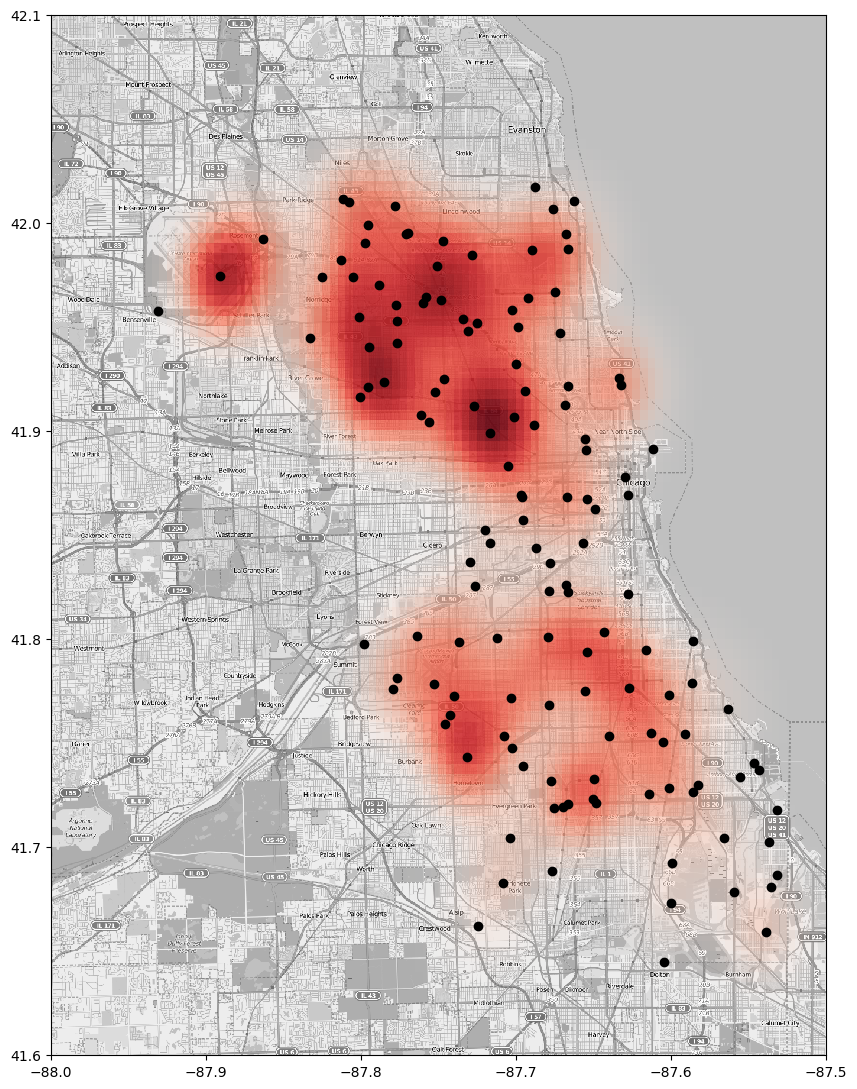

In [19]:
from sklearn.neighbors import KernelDensity

## X = WHAT WE ARE TRYING TO PLOT
## LOCATIONS = TRAPS


sightings = wnv_pop_age_temp_geog[(wnv_pop_age_temp_geog['WnvPresent'] > 0) & (wnv_pop_age_temp_geog["Year"]==2013)]
sightings_temp = sightings.groupby(['Date', 'Trap','Longitude', 'Latitude']).nunique()['WnvPresent'].reset_index()
X = sightings_temp[['Longitude', 'Latitude']].values
locations = wnv_pop_age_temp_geog[['Longitude', 'Latitude']].drop_duplicates().values

create_map(X, locations)

In [20]:
def spray_map(X, locations):

    mapdata = np.loadtxt("mapdata_copyright_openstreetmap_contributors.txt")
    alpha_cm = plt.cm.Blues
    alpha_cm._init()
    alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88, -87.5, 41.6, 42.1)

    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.figure(figsize=(10,20), dpi = 100)
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower', 
               cmap=alpha_cm, 
               extent=lon_lat_box, 
               aspect=aspect)
    
    # THIS PLOTS THE TRAPS LOCATIONS
    plt.scatter(locations[:,0], locations[:,1], marker='o', color = "blue")

    plt.savefig('spraymap.png')
    
    plt.show()

In [21]:
wnv_spray["Count"] = "1"

### SPRAY AREA PLOT

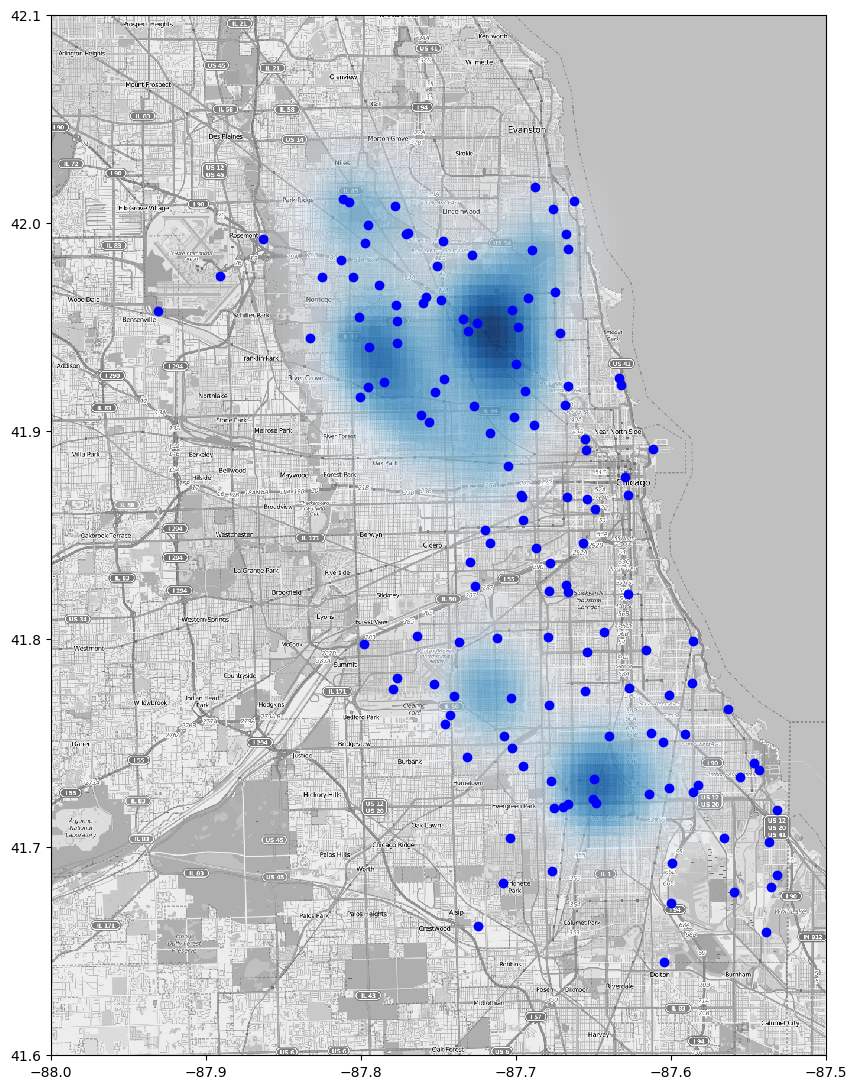

In [22]:
spray_2013 = wnv_spray[wnv_spray["Date"].dt.year==2013]
spray_temp = spray_2013.groupby(["Date", "Latitude", "Longitude"]).max()["Count"].reset_index()
spray_X = spray_temp[['Longitude', 'Latitude']].values
locations = wnv_pop_age_temp_geog[['Longitude', 'Latitude']].drop_duplicates().values

spray_map(spray_X, locations)

In [23]:
wnv_spray.head(5)

Date        Time   Latitude  Longitude  Year Count
0 2011-08-29  6:56:58 PM  42.391623 -88.089163  2011     1
1 2011-08-29  6:57:08 PM  42.391348 -88.089163  2011     1
2 2011-08-29  6:57:18 PM  42.391022 -88.089157  2011     1
3 2011-08-29  6:57:28 PM  42.390637 -88.089158  2011     1
4 2011-08-29  6:57:38 PM  42.390410 -88.088858  2011     1

### SPRAY RECOMMENDATIONS, USING DATA FROM MODEL!!

In [24]:
def spray_recos(X, locations, name):

    mapdata = np.loadtxt("mapdata_copyright_openstreetmap_contributors.txt")
    alpha_cm = plt.cm.Greens
    alpha_cm._init()
    alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88, -87.5, 41.6, 42.1)

    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.figure(figsize=(10,20), dpi = 100)
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower', 
               cmap=alpha_cm, 
               extent=lon_lat_box, 
               aspect=aspect)
    
    plt.savefig(name)

    
    # THIS PLOTS THE TRAPS LOCATIONS
    plt.scatter(locations[:,0], locations[:,1], marker='o', color = "black")
    
    plt.show()

In [25]:
#make sure you do 2013, and the 3 thresholds are agressive: .48, moderate: .5, conservative: .52

spray_recs["Count"]="1"
spray_agg = spray_recs[(spray_recs.year == 2013) & (spray_recs["spray_metric"]>6)][["latitude", "longitude", "date", "Count"]]
spray_mod = spray_recs[(spray_recs.year == 2013) & (spray_recs["spray_metric"]>7)][["latitude", "longitude", "date", "Count"]]
spray_cons = spray_recs[(spray_recs.year == 2013) & (spray_recs["spray_metric"]>8)][["latitude", "longitude", "date", "Count"]]


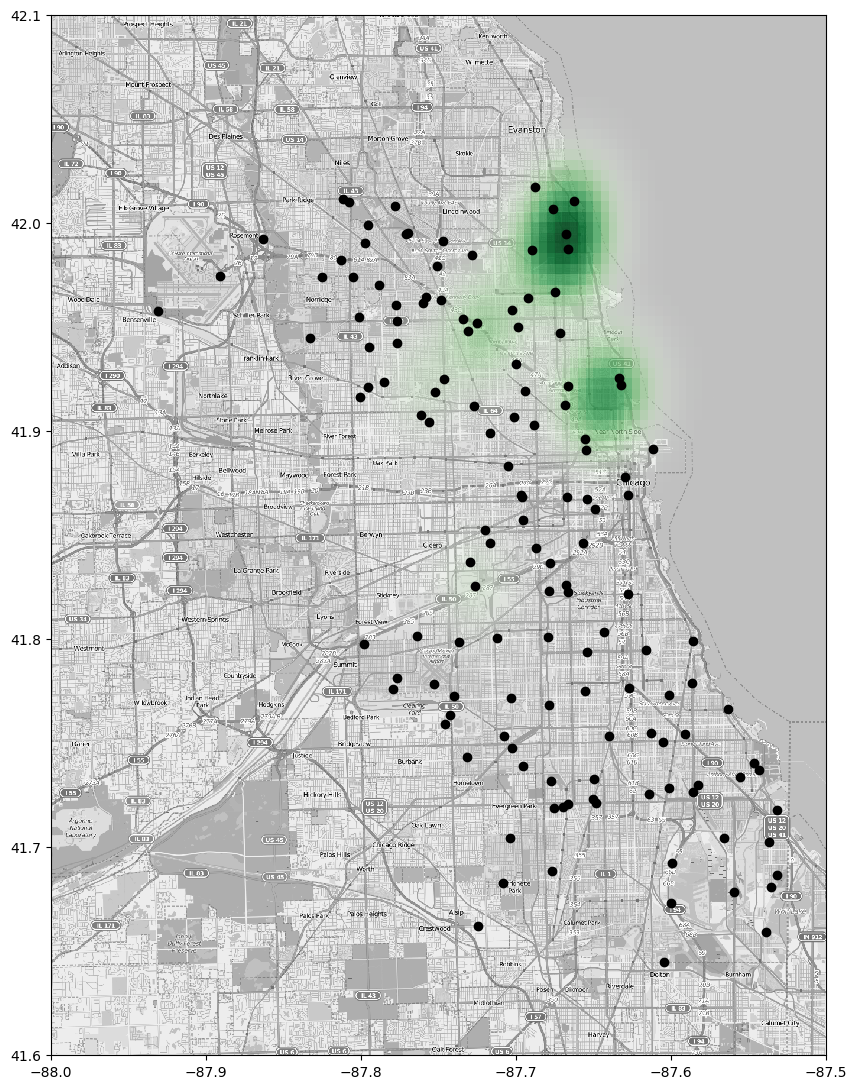

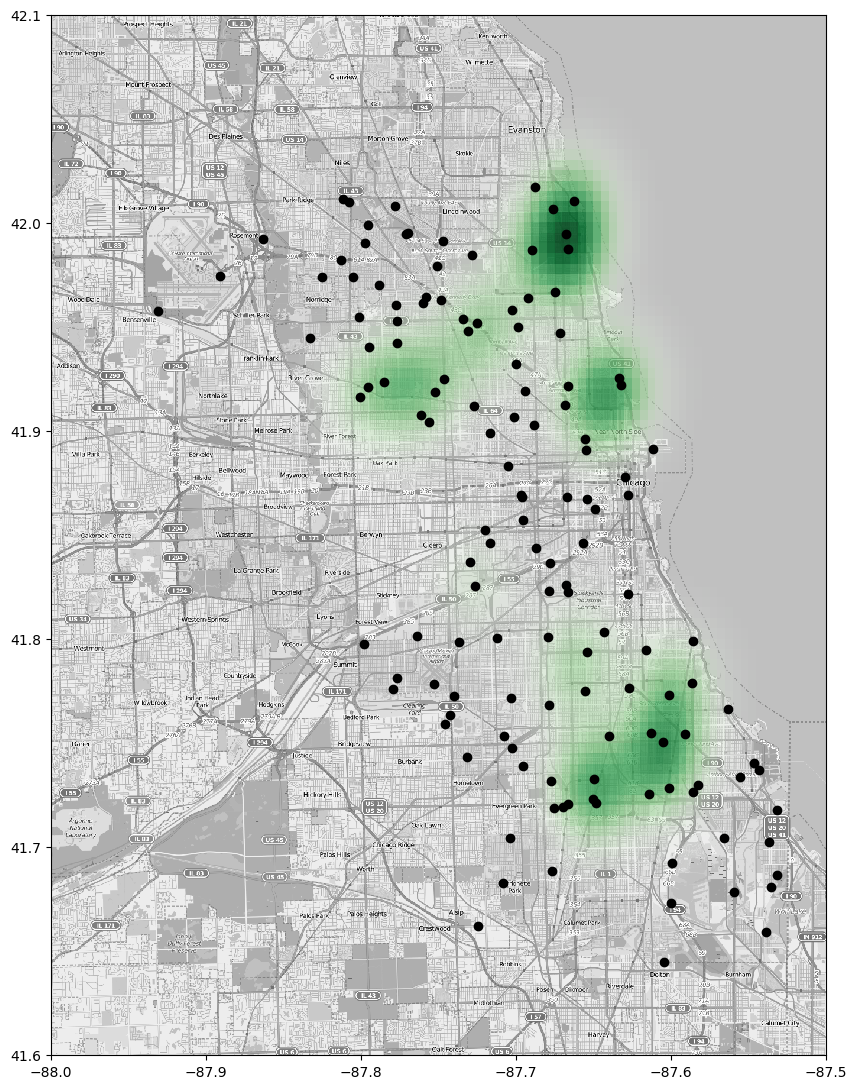

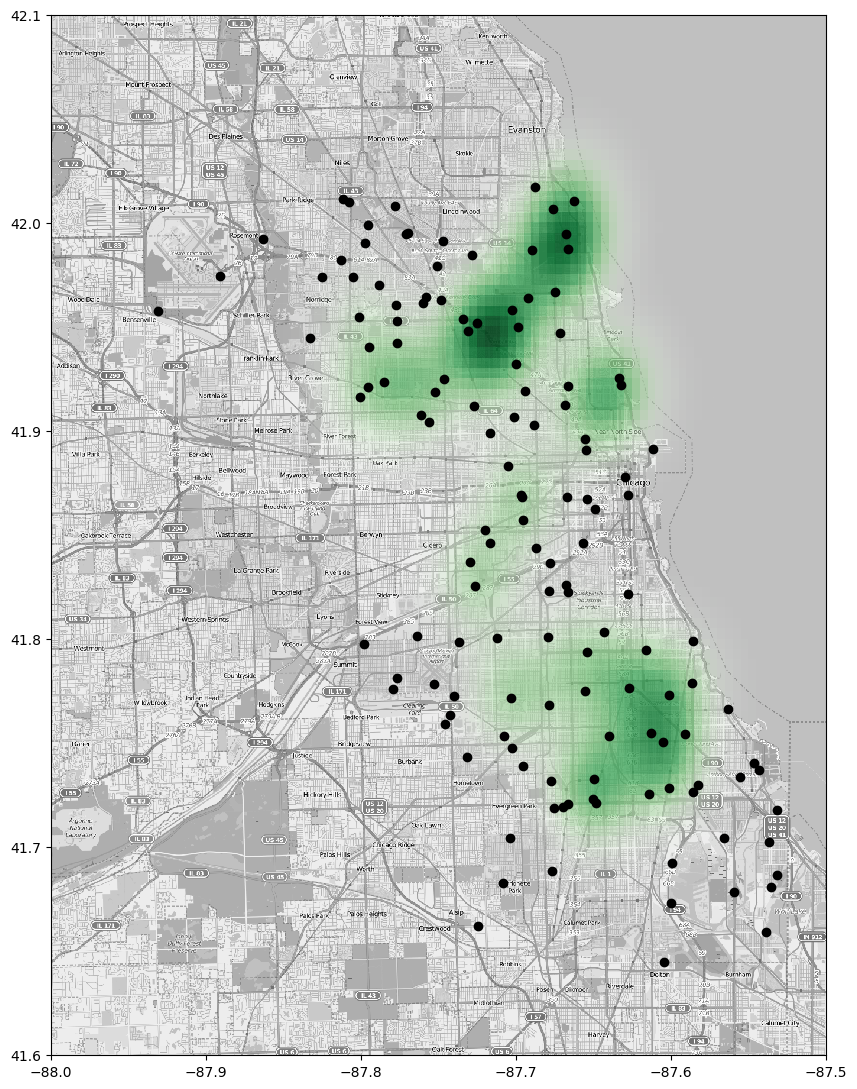

In [26]:
locations = wnv_pop_age_temp_geog[['Longitude', 'Latitude']].drop_duplicates().values
spray_cons_map = spray_cons[['longitude', 'latitude']].values
spray_recos(spray_cons_map, locations, "conservative.png")

spray_mod_map = spray_mod[['longitude', 'latitude']].values
spray_recos(spray_mod_map, locations, "moderate.png")

spray_agg_map = spray_agg[['longitude', 'latitude']].values
spray_recos(spray_agg_map, locations, "aggressive.png")



In [27]:
col_names = census_age.iloc[:, 2:].columns
for col in col_names:
    census_age[col] = census_age[col].astype(float, copy = False)

In [28]:
census_age["HighRisk%"] = census_age["percent_age_65_and_over"]
census_age["LowRisk%"] = 100-census_age["HighRisk%"]

census_age["HighRiskTotal"] = (census_age["HighRisk%"]*census_age["total_population"]/100).astype(int)
census_age["LowRiskTotal"] = (census_age["LowRisk%"]*census_age["total_population"]/100).astype(int)

In [29]:
chicago_zips = wnv_data["ZipCode"].drop_duplicates().reset_index()

census_chicago = pd.merge(chicago_zips, census_age, left_on = "ZipCode", right_on='zip_code', how = 'left')

high_risktotal = census_chicago["HighRiskTotal"].sum(axis = 0)
low_risktotal = census_chicago["LowRiskTotal"].sum()


### OTHER INFO THAT WE ARE PLOTTING ON GRAPHS

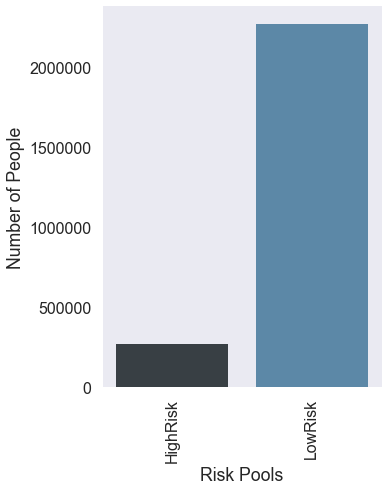

In [30]:
#chart for bigger bar chart", "#508AB3"
plt.rcParams['figure.figsize'] = 5,7
sns.set_style("darkgrid")
sns.set_context("poster")
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(y= [high_risktotal, low_risktotal], x = ["HighRisk", "LowRisk"], palette=["#363F46", "#508AB3"])
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
ax.grid(False)
ax.set(xlabel='Risk Pools', ylabel='Number of People')
       #title = 'Leading Causes of Death in Chicago in 2013
plt.xticks(rotation=90)
plt.savefig('highlowrisk.png')
plt.show()


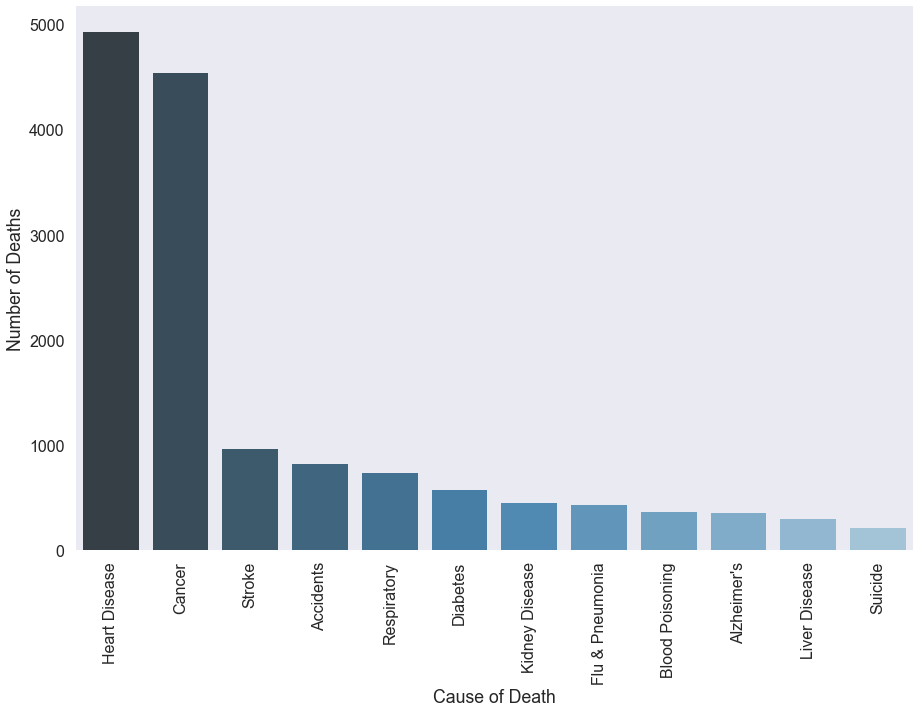

In [31]:
#data for bigger bar chart showing leading causese of death

plt.rcParams['figure.figsize'] = 15,10
deaths = [4927, 4536, 731, 957, 819, 351, 572, 449, 430, 366, 206, 294]
colsquick = ['Heart Disease',
       'Cancer', 'Respiratory',
       'Stroke','Accidents', 'Alzheimer\'s','Diabetes',
       'Kidney Disease','Flu & Pneumonia',
       'Blood Poisoning', 'Suicide', 'Liver Disease']

deaths_pd = pd.DataFrame({"Causes": colsquick, "Deaths": deaths})
deaths_pd = deaths_pd.sort_values("Deaths", ascending=False)

#data for smaller just comparing flue versus wnv
colalt = ['Flu & Pneumonia', 'West Nile Virus']
deathalt = [430,7]

#chart for bigger bar chart
ax = sns.barplot(y= "Deaths", x = "Causes", data = deaths_pd, palette=("Blues_d"))
sns.set_context("poster")
ax.grid(False)
ax.set(xlabel='Cause of Death', ylabel='Number of Deaths', 
       #title = 'Leading Causes of Death in Chicago in 2013'
      )
plt.xticks(rotation=90)
plt.savefig('diseases.png')
plt.show()




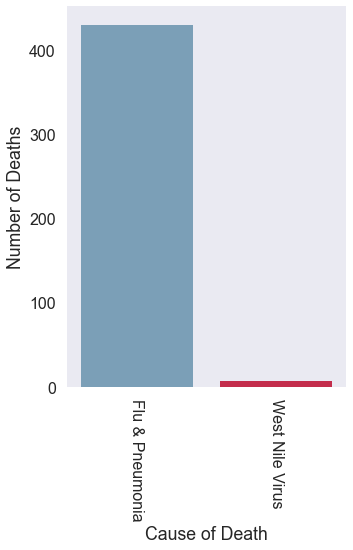

In [32]:
#chart for smaller bar chart
plt.rcParams['figure.figsize'] = 5,7
plt.xticks(rotation=-90)
ax = sns.barplot(y= deathalt, x = colalt, palette=["#71A1C1", "crimson"])
ax.grid(False)
ax.set(xlabel='Cause of Death', ylabel='Number of Deaths',)
plt.rcParams['savefig.dpi'] = 200
plt.savefig('wnv_deaths.png')
plt.show()


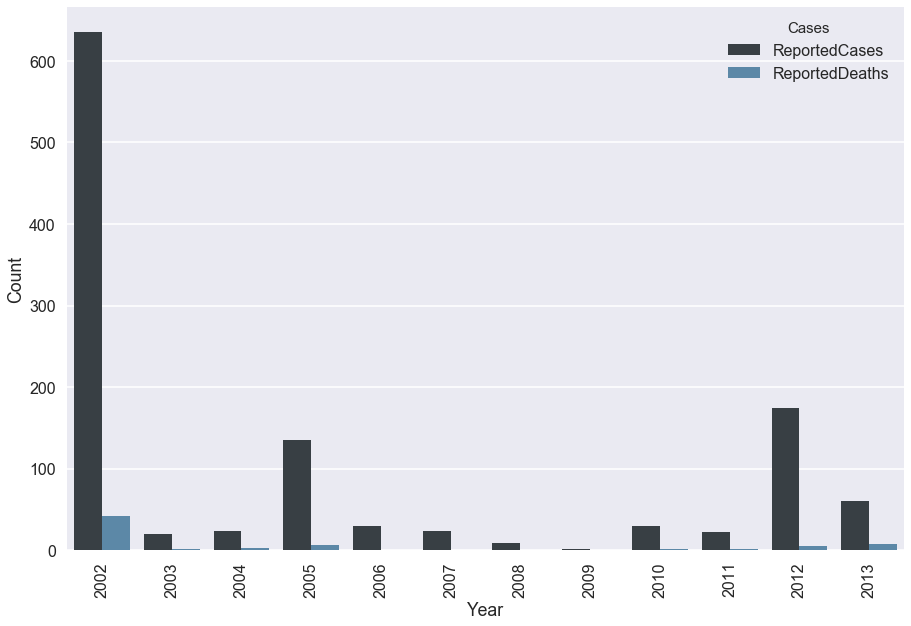

In [33]:
plt.rcParams['figure.figsize'] = 15,10
wnv_years = []
for i in range(2002,2014):
    wnv_years.append(str(i))
wnv_cases = [635, 20, 23, 135, 29, 23, 9, 1, 30, 22, 174, 60]
wnv_deaths = [42, 1, 2, 6, None, 0, 0, 0, 1, 1, 5, 7]

wnv_casedeaths = pd.DataFrame({"Year": wnv_years, "ReportedCases": wnv_cases, "ReportedDeaths" : wnv_deaths})

wnv_cases = pd.melt(wnv_casedeaths, id_vars="Year", var_name="Cases", value_name="Count")
wnv_cases = wnv_cases.dropna()

sns.set_context("poster")
plt.xticks(rotation=90)
sns.barplot(x = "Year", y = "Count", data = wnv_cases, hue = "Cases", palette=["#363F46", "#508AB3"])
plt.savefig('wnv_casesdeaths.png')
plt.show()


### PLOT THE COST/SAVINGS CHART HERE USING CHRIS PREDICTIONS

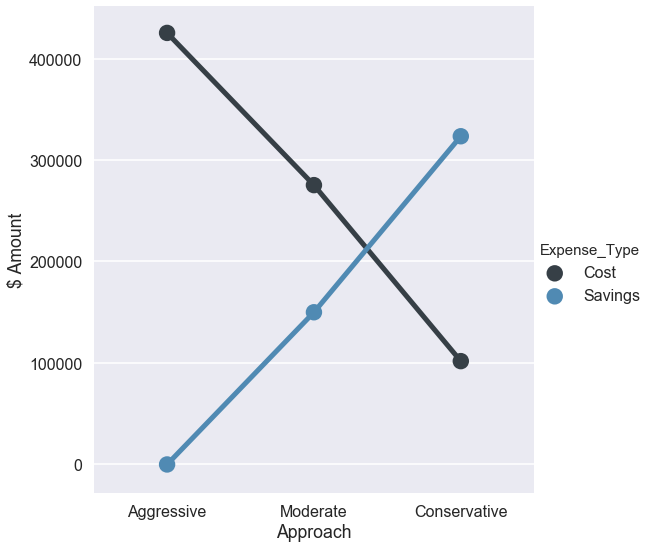

In [35]:
plt.rcParams['figure.figsize'] = 15,10

approaches_cost = [425500, 275250, 101500] ## FROM CHRIS MODEL
approaches_savings = [-500, 149750, 323500] # SUBTRACT COST FROM 425000
cols_approach = ["Aggressive", "Moderate", "Conservative"] # TYPES OF APPROACHES


#chart for bigger bar chart
wnv_approaches = pd.DataFrame({"Approach": cols_approach, "Cost": approaches_cost, "Savings" : approaches_savings})

approaches_plot = pd.melt(wnv_approaches, id_vars="Approach", var_name="Expense_Type", value_name="$ Amount")

sns.set()
sns.set_style("darkgrid")
sns.set_context("poster")
sns.set_context(context = None)
ax = sns.factorplot(x = "Approach", y = "$ Amount", data = approaches_plot, hue = "Expense_Type", palette=["#363F46", "#508AB3"], kind = "point", size = 8)
plt.savefig('cost_savings.png')
plt.show()
